# Machine Learning for Natural Language Processing : Fake news classification - Quentin MASCART & Raphaëlle VILLERS

Social networks and Internet forums have become a partial source of information for many users, an exclusive source of information for some. Given potential instrumentation of those news media channels, automatic detection of fake news through NLP processing and modelling could offer scale-efficient regulation.

# I. Packages et jeu de donnée


Data is available here on Kaggle : https://www.kaggle.com/c/fake-news-pair-classification-challenge/data?fbclid=IwAR2R1ZOoT6dw1jhm5VDVOzn2Lpihx-oig69gDELhan0dRwtsIbTWpNhNUdE 

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.1MB/s 
     |████████████████████████████████| 3.3MB 51.7MB/s 
     |████████████████████████████████| 870kB 55.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=ce85c5359eedb9b40efd302abedd3b31c6f9e2002425c6d40599cba56741046c
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [1]:
#Pour la gestion des données
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

#Pour la tokenisation
from nltk.tokenize import TreebankWordTokenizer
import re

#Pour le prétraitement des données
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

#Pour la classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

#Pour l'évaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
! wget https://raw.githubusercontent.com/rmoutarde/NLP_project/main/sampled_train.zip

--2021-04-21 08:51:39--  https://raw.githubusercontent.com/rmoutarde/NLP_project/main/sampled_train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11686103 (11M) [application/zip]
Saving to: ‘sampled_train.zip’

sampled_train.zip   100%[===================>]  11.14M  33.5MB/s    in 0.3s    

2021-04-21 08:51:40 (33.5 MB/s) - ‘sampled_train.zip’ saved [11686103/11686103]



In [5]:
! unzip sampled_train.zip

Archive:  sampled_train.zip
  inflating: sampled_train.csv       


In [6]:
df_news = pd.read_csv(r"sampled_train.csv", error_bad_lines=False,encoding='UTF-8').dropna().sample(frac=1)
df_news=df_news.replace({'unrelated':0 ,'disagreed' : 1, 'agreed' : 2})

In [9]:
df_news['title1_en'][18]

'2018 Social Security Reform Future right to the new policy, the rural old age problems will be at a time!'

In [10]:
df_news.groupby('label').count()['id']

label
0    42230
1     1211
2    16558
Name: id, dtype: int64

La base est n'est pas très balanced : très peu de disagreed, beaucoup de unrelated. Regarder comment gérer ça : peut-être augmenter artificiellement une certaine classe.

# II. Tokenisation et nettoyage de la base

On tokenise juste en enlevant les stop word à l'aide de TreebankWordTokenizer. En effet, la base est très propre.

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords
  
def tokenize_remove(corpus):
    corpus=remove_stopwords(corpus)
    corpus_token=TreebankWordTokenizer().tokenize(corpus)
    return corpus_token

On regroupe les mots qui fonctionne de pair. Par exemple beaucoup de personnalité politique eg : Donald Trump, Barak Obama

In [ ]:
# we suggest using the Phrases module to train the multi-word detector then iterating on the output to display the results (first 15 for instance)
from gensim.models.phrases import Phrases, Phraser

def show_phrases(tokenized_sentences, threshold=10, shown=15):
  # Training the multi-word expression detector
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  i = 0
  for phrase, score in phrases.export_phrases(tokenized_sentences):
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

Cette fonction crée la tokenisation

In [ ]:
def clean_corpus(corpus, threshold=50):
  tokenized_sentences = corpus.progress_apply(lambda x: tokenize_remove(x)).array
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

In [ ]:
#Répartition des labels dans ce que l'on va utiliser pour entrainer et tester le modèle.
df_news[0:10000].groupby('label').count()['id']

label
0    6882
1     240
2    2878
Name: id, dtype: int64

In [ ]:
X_1 = clean_corpus(df_news.title1_en[0:10000].astype(str), threshold = 300)
X_1 = [' '.join(x) for x in X_1]

X_2 = clean_corpus(df_news.title2_en[0:10000].astype(str), threshold = 300)
X_2 = [' '.join(x) for x in X_2]

In [ ]:
X=pd.DataFrame(columns=['texte_1','texte_2'])
X['texte_1']=X_1
X['texte_2']=X_2
X=X.texte_1+X.texte_2

In [ ]:
#X=pd.DataFrame(columns=['texte_1','texte_2'])
#X['texte_1']=df_news.title1_zh[0:10000]
#X['texte_2']=df_news.title2_zh[0:10000]
#X=X.texte_1+X.texte_2

In [ ]:
y = df_news.label[0:10000]

# III. Classification


## III. 1. Train/test

In [ ]:
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)

# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)

## III. 2. Prétraitement des données

Nous commençons par vectoriser le texte grâce à Count_vectorizer

In [ ]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

# for dev set
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(2000, 14354)

In [ ]:
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(6000, 3) (2000, 3)


## III. 3. SVM

In [ ]:
from sklearn import svm
svc = svm.SVC(kernel='linear', probability=True)
clf_svm = OneVsRestClassifier(svc)
# now we train again
clf_svm = clf_svm.fit(X_train_cv, y_train_lb)

In [ ]:
# instead of clf_svm.predict() we use clf_svm.decision_function() to retrieve the prob scores
# we put it into another variable in order to enable comparison at any time between y_pred_svm and y_score_svm
y_score_svm = clf_svm.decision_function(X_dev_cv)

## III. 4. Evaluation du modèle pour la classification

### a) Evaluation quantitative

In [ ]:
def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names))
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['unrelated','disagreed','agreed']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1411
           1       0.21      0.06      0.10        48
           2       0.45      0.47      0.46       541

    accuracy                           0.68      2000
   macro avg       0.48      0.44      0.44      2000
weighted avg       0.67      0.68      0.67      2000



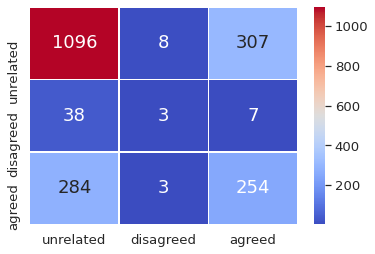

unrelated 0.6638309956093223
disagreed 0.674436475409836
agreed 0.7125965547516276


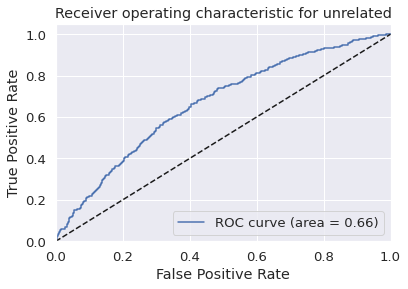

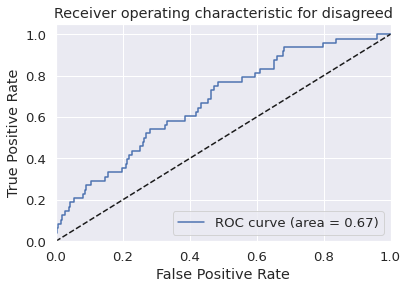

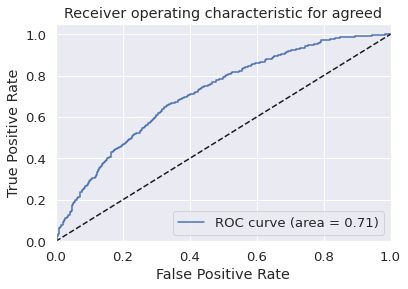

In [ ]:
show_eval(y_dev_lb, y_score_svm, lb_trained, clf_svm)

### b) Evaluation qualitative

Prenons deux phrases aux hasard et collons les pour voir ce que cela ressort.

In [ ]:
print(df_news.title1_en.reset_index(drop=True)[57])
print(df_news.title2_en.reset_index(drop=True)[30])
X_quali=X_1[57]+X_2[30]
X_quali
X_cv = cv.transform([X_quali])

Is it true that Yang Zhi-Qin's love affair is true? "The Qiaozhou couple" is embarrassed to untie, and Chen Weiying of Chen Weiqing falls into a falling out?
guangxi longbang station launches solemn oath to celebrate international police day


In [ ]:
y_score_quali_1 = clf_svm.decision_function(X_cv)
print(y_score_quali_1)

[[ 1.36109735 -1.64206834 -1.21126805]]


In [ ]:
print(df_news.title1_en.reset_index(drop=True)[0])
print(df_news.title2_en.reset_index(drop=True)[0])
X_quali=X_1[0]+X_2[0]
X_cv = cv.transform([X_quali])

xiao yang found guilty of crime and sent to jail
Shenyang got caught and sent to jail. Song Po-tao sighs.


In [ ]:
y_score_quali_2 = clf_svm.decision_function(X_cv)
print(y_score_quali_2)

[[-0.63907726 -1.70546541  0.83367083]]


Identifie correctement en unrelated et en agree

## IV. 5. Ajustement du modèle

### a) Idée : Changer la fonction de coût pour donner plus de poids aux erreurs qui classifient mal les disagree

In [ ]:
def prediction(y_score):
  y_pred=[]
  for i in range(len(y_score)):
    y_pred.append(np.argmax(y_score[i]))
  return y_pred

In [ ]:
#Nous créons une matrice de coût. Nous voulons que les classes 2 aient plus de poids que les 1/2
A=np.ones((3, 3))-np.eye(3, 3)
A[0,1]=3
A[2,1]=3
A

array([[0., 3., 1.],
       [1., 0., 1.],
       [1., 3., 0.]])

In [ ]:
def cost_matrix(y, y_pred):
    conf = confusion_matrix(y.argmax(axis=1), prediction(y_pred))
    cost_matrix = A
    total_cost = np.multiply(conf, cost_matrix).sum()
    return 1-total_cost/len(y)

In [ ]:
from sklearn.metrics import make_scorer
my_scorer=make_scorer(cost_matrix, greater_is_better=False)

In [ ]:
# SVM Classifier + Pipeline + New score function
model_to_set = OneVsRestClassifier(svm.SVC(kernel="linear"))

parameters4 = {'estimator__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
my_scorer = make_scorer(cost_matrix, greater_is_better=True)

svm_matrix = GridSearchCV(model_to_set, parameters4, cv=3, scoring=my_scorer)

svm_matrix.fit(X_train_cv, y_train_lb)


print('Returned hyperparameter: {}'.format(svm_matrix.best_params_))
print('Best Balanced accuracy in train is: {}'.format(svm_matrix.best_score_))

NameError: ignored

In [ ]:
svm_custom_score=svm_matrix.decision_function(X_dev_cv)

### b) Evaluation quantitative

In [ ]:
show_eval(y_dev_lb, svm_custom_score, lb_trained, clf4)

NameError: ignored

Ca a l'air d'avoir fonctionné, cependant pas beaucoup de disagree pour vérifier. Voyons à la main.

### c) Evaluation qualitative

In [ ]:
df_disagree=df_news[df_news['label']==1]

X_1 = clean_corpus(df_disagree.title1_en[0:10000].astype(str), threshold = 300)
X_1 = [' '.join(x) for x in X_1]

X_2 = clean_corpus(df_disagree.title2_en[0:10000].astype(str), threshold = 300)
X_2 = [' '.join(x) for x in X_2]

X=pd.DataFrame(columns=['texte_1','texte_2'])
X['texte_1']=X_1
X['texte_2']=X_2
X=X.texte_1+X.texte_2

X_disagree_cv = cv.transform(X)

100%|██████████| 1464/1464 [00:00<00:00, 10450.11it/s]


In [ ]:
svm_custom_score_disagree=clf4.decision_function(X_disagree_cv)
print(prediction(svm_custom_score_disagree).count(0))
print(prediction(svm_custom_score_disagree).count(1))
print(prediction(svm_custom_score_disagree).count(2))

1327
64
73


C'est très mauvais. Essayons avec un weighted average f1 score

### d) Nouvel ajustement

In [ ]:
from sklearn.metrics import f1_score
# SVM Classifier + Pipeline + New score function

model_to_set = OneVsRestClassifier(svm.SVC(kernel="linear"))

parameters4 = {'estimator__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
balanced_scorer = make_scorer(f1_score, average='weighted')

clf_svm_f1w = GridSearchCV(model_to_set, parameters4, cv=3, scoring=balanced_scorer)
clf_svm_f1w.fit(X_train_cv, y_train_lb)

print('Returned hyperparameter: {}'.format(clf_svm_f1w.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf_svm_f1w.best_score_))

Returned hyperparameter: {'estimator__C': 0.125}
Best Balanced accuracy in train is: 0.7397489669392824


In [ ]:
svm_f1_score=clf_svm_f1w.decision_function(X_dev_cv)

array([[ 1.25444092, -1.06267905, -2.14940136],
       [ 3.24885935, -0.93448172, -5.20013413],
       [-0.90479705, -1.42291483,  0.94252804],
       ...,
       [ 1.70154441, -1.37770527, -1.88633112],
       [ 0.70487872, -1.05771476, -1.30041838],
       [ 0.97068946, -1.334162  , -0.94781336]])

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1399
           1       0.56      0.12      0.19        43
           2       0.65      0.55      0.60       558

    accuracy                           0.77      2000
   macro avg       0.67      0.52      0.54      2000
weighted avg       0.76      0.77      0.76      2000



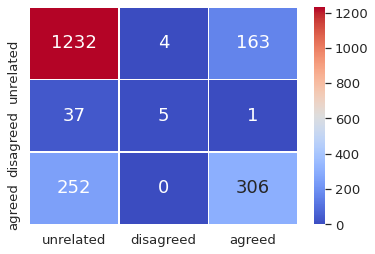

unrelated 0.784434805464802
disagreed 0.8188019156040925
agreed 0.8211713122455371


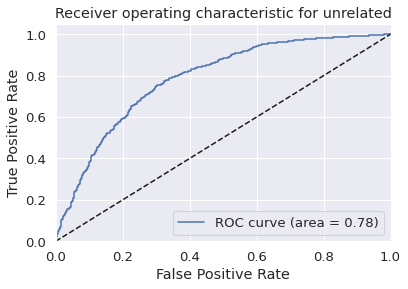

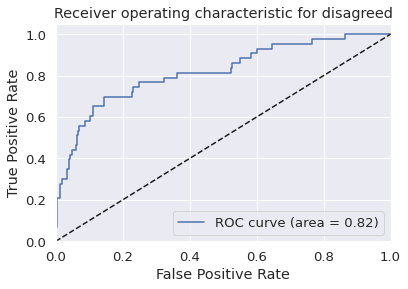

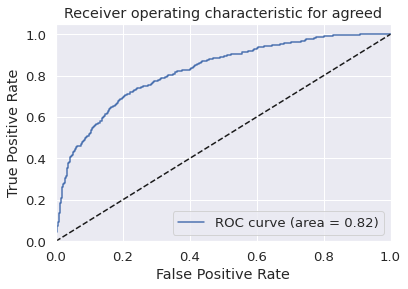

In [ ]:
svm_f1_score=clf_svm_f1w.decision_function(X_dev_cv)
show_eval(y_dev_lb, svm_f1_score, lb_trained, clf4)

Essayons d'avoir plus de disagree dans notre base de train.

In [ ]:
svm_custom_score_disagree=clf_svm_f1w.decision_function(X_disagree_cv)
print(prediction(svm_custom_score_disagree).count(0))
print(prediction(svm_custom_score_disagree).count(1))
print(prediction(svm_custom_score_disagree).count(2))

1240
138
86


Mieux que ce qu'on avait tout à l'heure

# IV. LSTM

## IV. 1. Créons le vocabulaire

In [ ]:
word_to_ix = {}
for i in tqdm(range(len(X))):
    for word in X[i]:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
tag_to_ix = {}
for tag in y:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)
            
print(tag_to_ix)


{0: 0, 2: 1, 1: 2}


## IV. 2. Architecture du réseau

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SequenceLabeller(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes, sequence_model="LSTM"):
        super(SequenceLabeller, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        if sequence_model == "LSTM":
            # The LSTM takes word embeddings as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.seq = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        else:
            raise(Exception("Sequence model {} not supported".format(sequence_model)))

        # The linear layer that maps from hidden state space to class space
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        seq_output, (h_n,c_n) = self.seq(embeds)
        tag_space = self.hidden2tag(seq_output)
        # Although we will be performing binary classification, this is a 
        # general implementation displaying what should be done for n_classes>2
        tag_scores = F.log_softmax(tag_space, dim=2) # Computationally efficient for the criterion
        return tag_scores

In [ ]:
data=[]
for i,j in zip(X,y):
    data.append((i,j))

training_data = data[:int(len(data)*4/5)][0:4000]
test_data = data[int(len(data)*4/5):][0:2000]

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else len(to_ix) for w in seq]
    idxs = torch.tensor(idxs, dtype=torch.long).unsqueeze(0)
    return idxs

## IV. 3. Entrainement du réseau

In [ ]:
# the additional vocabulary element is to account for unkown words
model = SequenceLabeller(50, 100, len(word_to_ix)+1, len(tag_to_ix)) 
inputs = prepare_sequence(training_data[0][0], word_to_ix)
with torch.no_grad():
    sent_scores = model(torch.cat([inputs]))
    print("Input tokens {} scores {} ".format(inputs, sent_scores))

In [ ]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

In [ ]:
from torch.nn.functional import one_hot
from multiprocessing import cpu_count
cpu = cpu_count()
print('The virtual instance has {} cpus'.format(cpu))

n_epochs = 3
for epoch in range(n_epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    loss_mean_ep = 0
    n_sample = 0
    for sentence, tags in tqdm(training_data):
        if len(sentence) < 2: continue
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        #import pdb
        #pdb.set_trace()
        targets = prepare_sequence([tags], tag_to_ix)
        one_hot_targets = one_hot(targets.squeeze(0), num_classes=len(tag_to_ix))
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        #import pdb
        #pdb.set_trace()
        # print(tag_scores.shape, one_hot_targets.shape)
        loss = loss_function(tag_scores, one_hot_targets)
        loss_mean_ep += loss
        n_sample += 1
        loss.backward()
        optimizer.step()
    print("Epoch {} loss {:0.4f} ".format(epoch, loss/n_sample))

The virtual instance has 2 cpus



Epoch 0 loss 0.0002 



Epoch 1 loss 0.0002 



Epoch 2 loss 0.0002 


## IV. 4. Evaluation du modèle 

In [ ]:
with torch.no_grad():
    y_pred=[]
    y_true=[]
    for sentence, tag in tqdm(test_data):
        pred=[]
        sentence_in = prepare_sequence(sentence, word_to_ix)
        tag_scores = model(sentence_in)
        for i in range(3):
          pred.append(torch.mean(torch.exp(tag_scores.squeeze(0)[:, i])).item())
        y_pred.append(np.argmax(pred))
        y_true.append(tag)

In [ ]:
def show_eval(y_true, y_pred):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred) 
  labels = ['unrelated','disagreed','agreed']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.68      1.00      0.81      1367
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00       581

    accuracy                           0.68      2000
   macro avg       0.23      0.33      0.27      2000
weighted avg       0.47      0.68      0.56      2000



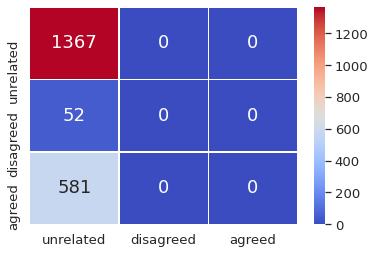

In [ ]:
show_eval(y_true,y_pred)

Que des 0, le résultat est étrange. Nous n'avons pas réussi a voir où était le problème.



# V. BERT model and finetuning

## V. 1. GPU

In [ ]:
!nvidia-smi

Sat Apr 17 08:59:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## V. 2. Chargeons les données

### Train/test

In [ ]:
test_size=0.10
df=df_news[0:50000].copy()
#frac=1 : on shuffle les données.
train=df.head(int(len(df)*(1-test_size))).sample(frac=1).reset_index(drop=True)
test=df.tail(int(len(df)*(test_size))).sample(frac=1).reset_index(drop=True)

### Pour intégrer dans pytorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader

class Fake_news_dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, maxlen, model_name='bert-base-uncased'):

        #Store the contents of the file in a pandas dataframe
        self.dataset = dataframe

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame

        sentence = self.dataset['title1_en'][index]+self.dataset['title2_en'][index]
        label = self.dataset['label'][index]

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        if self.tokenizer.cls_token is None:
            bos_token = self.tokenizer.bos_token
        else:
            bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
            eos_token = self.tokenizer.eos_token
        else:
            eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [ ]:
train_set = Fake_news_dataset(dataframe = train, maxlen = 30, model_name='bert-base-uncased')
val_set = Fake_news_dataset(dataframe = test, maxlen = 30, model_name='bert-base-uncased')

In [ ]:
train_loader = DataLoader(train_set, batch_size = 32, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 1, num_workers = 5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## V. 3. Entrainement du modèle

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 3)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(pool)

        return logits

In [ ]:
# we now instansiate the model 
#sentiment_model = SentimentClassifier('bert-base-uncased')
# if gpu mode
#sentiment_model = sentiment_model.to("cuda")
# to check if the weights of the model are in gpu : 
# sentiment_model.cls_layer.weight.is_cuda
# can checkout all the layers by running 
sentiment_model = SentimentClassifier('bert-base-uncased')
# if gpu mode
sentiment_model = sentiment_model.to("cuda")
# to check if the weights of the model are in gpu : 
# sentiment_model.cls_layer.weight.is_cuda
# can checkout all the layers by running 
#sentiment_model

In [ ]:
import torch.nn as nn
import torch.optim as optim
# define the loss and optimizer 
criterion = nn.CrossEntropyLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 1e-4)

In [ ]:
import pdb
def train(model, criterion, opti, train_loader, val_loader, max_eps=5, gpu=False, print_every=1,validate_every=1, break_training_after=None):
    if gpu:
      model = model.to("cuda")
    for ep in tqdm(range(max_eps)):
        
        for it, (seq, attn_masks, labels) in tqdm(enumerate(train_loader)):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits = model(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels)

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()

In [ ]:
train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=5, print_every=10, gpu=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
import gc
def clearRAM():
  gc.collect()
  torch.cuda.empty_cache()

#del y_pred
clearRAM()
! nvidia-smi

Sun Apr 18 08:45:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |   1524MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## V. 4. Prédiction et évaluation du modèle

In [ ]:
import pdb
def validation(model, val_loader, max_eps=1, gpu=False):
  model.eval()
  with torch.no_grad():
    y_pred=[]
    if gpu:
      model = model.to("cuda")
    for ep in range(max_eps):
      for it, (seq, attn_masks, labels) in enumerate(tqdm(val_loader)):
      #Converting these to cuda tensors
        if gpu:
          seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
        #Obtaining the logits from the model
        logits = model(seq, attn_masks)
        y_pred.append(logits)
  return y_pred

In [ ]:
y_pred=validation(sentiment_model, val_loader, gpu=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1018 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
y_pred_label=[]
for i in range(len(y_pred)):
  y_pred_label.append(np.argmax(y_pred[i][0].detach().cpu().numpy()))

In [ ]:
def show_eval(y_true, y_pred):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred) 
  labels = ['unrelated','disagreed','agreed']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3471
           1       0.27      0.28      0.27       119
           2       0.71      0.52      0.60      1410

    accuracy                           0.78      5000
   macro avg       0.60      0.57      0.58      5000
weighted avg       0.77      0.78      0.77      5000



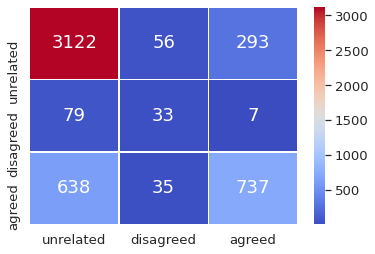

In [ ]:
show_eval(test.label, y_pred_label)

In [ ]:
balanced_accuracy_score(test.label, y_pred_label)

0.5664861890495055